Se cargo la base de datos sacada del INEGI ya limpiado pib_turismo.csv y mostre el Shape junto con las primeras filas. Confirmo que tengo 5 columnas y 1860 registros. Me srirve para verificar que los campos que voy a usar existen y que el tamaño del conjunto es suficiente para modelar

In [59]:
import pandas as pd
import numpy as np

pib_turismo = pd.read_csv("pib_turismo.csv")
print("Shape:", pib_turismo.shape)
pib_turismo.head()


Shape: (1860, 5)


,anio,tipo_precio,unidad_medida,categoria_detalle,valor_millones_pesos
0,1993,corrientes,Millones de pesos a precios corrientes,Total del país,1585848.139
1,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico,172419.669
2,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Bienes,23123.423
3,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Bienes|Artesanías,10674.629
4,1993,corrientes,Millones de pesos a precios corrientes,Total del país|Total turístico|Bienes|Otros bi...,12448.794


Me quedé con las dos variables numéricas que voy a graficar en 2D: anio y valo_millones_pesos. También imprimí el rango de valor_millones_pesos (mínimo y máximo). Ese rango muestra que la escala económica es grande y heterogénea, lo que justifica estandarizar después para que ambas variables queden comparables en las gráficas y en los modelos lineales. Las magnitudes de anio y del PIB son muy diferentes

In [61]:
features_num = ["anio", "valor_millones_pesos"]
for c in features_num:
    assert c in pib_turismo.columns, f"No se encontró la columna {c}"

X_num = pib_turismo[features_num].copy()

y_cont = pib_turismo["valor_millones_pesos"].astype(float)  
print("Rango valor_millones_pesos:", float(y_cont.min()), "-", float(y_cont.max()))


Rango valor_millones_pesos: 85.228 - 29938940.74


Hice el split 70% entrenamiento y 30% prueba. Con solo los datos de entrenamiento calculé la mediana de valor_millones_pesos y formé una clase binaria: 0=Bajo y 1=Alto según si cada  observación queda por debajo o por encima de ese umbral. La salida imprime el valor del umbral y las proporciones de cada clase en train y test. Con eso demuestro que no hubo fuga de información y las clases quedan balanceadas en ambos conjuntos

In [62]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_cont_train, y_cont_test = train_test_split(
    X_num, y_cont, test_size=0.30, random_state=55, stratify=None
)

umbral = y_cont_train.median()
print("Umbral (mediana en TRAIN):", float(umbral))

y_train = (y_cont_train >= umbral).astype(int).reset_index(drop=True)
y_test  = (y_cont_test  >= umbral).astype(int).reset_index(drop=True)

X_train = X_train_raw.reset_index(drop=True)
X_test  = X_test_raw.reset_index(drop=True)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("\nDistribución de clases (train):")
print(y_train.value_counts(normalize=True).round(3))
print("\nDistribución de clases (test):")
print(y_test.value_counts(normalize=True).round(3))


Umbral (mediana en TRAIN): 34963.588
Train: (1302, 2) Test: (558, 2)

Distribución de clases (train):
valor_millones_pesos
1    0.5
0    0.5
Name: proportion, dtype: float64

Distribución de clases (test):
valor_millones_pesos
1    0.556
0    0.444
Name: proportion, dtype: float64


Transfformé anio y valor_millones_pesos a anio_z y valor_millones_pesos_z con media 0 y desviación 1. El head() que aparece confirma que las nuevas columnas están centradas. Esta estandarización no cambia que solo pone ambas variables en la misma escala para que la frontera de LDA se bea limpia y el árbol no se sesgue por magnitudes distintas.

In [63]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
Xs_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=[f"{c}_z" for c in X_train.columns]
)
Xs_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=[f"{c}_z" for c in X_test.columns]
)

Xs_train.head()


,anio_z,valor_millones_pesos_z
0,0.778125,-0.160800
1,-0.875857,-0.171303
2,-1.206653,-0.210885
3,1.219187,-0.093398
4,0.667860,6.236368


Hice una regresión logística (GLM binomial) usando anio_z y valor_millones_pesos_z.
El summary que imprimí muestra lo siguente en mi salida:
- N = 1302 observaciones, Df Residuals = 1299, Deviance =7.1917e-05, Pearson chi2 = 3.60e-05.
  Coeficientes:
- const = 2.147e+05, z= 0.537, p = 0.592
- anio_z = 22.5853, z = 0.0, p = 1.0
- valor_millones_pesos_z = 9.983+05, z = 0.553, p = 0.580
Use como TOP-2 las mismas dos variables que uso en todo el flujo: (anio_z, valor_millones_pesos_z).

Como la clase se construyó justamente con valor_millones_pesos, el GLM muestra señales de separación fuerte, aqui el objetivo es documentar y justificar las dos variables, no hacer inferencia causal

In [66]:
import numpy as np
import statsmodels.api as sm
import warnings
import io, contextlib
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning

X_glm = sm.add_constant(Xs_train, has_constant='add')

errbuf = io.StringIO()
old_np = np.seterr(all="ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
    with contextlib.redirect_stderr(errbuf):
        res = sm.GLM(y_train.astype(float), X_glm, family=sm.families.Binomial()).fit()
        summ = res.summary() 

np.seterr(**old_np)  

print(summ)

top2_vars = list(Xs_train.columns)
print("\nTOP-2 variables seleccionadas:", top2_vars)

                  Generalized Linear Model Regression Results                   
Dep. Variable:     valor_millones_pesos   No. Observations:                 1302
Model:                              GLM   Df Residuals:                     1299
Model Family:                  Binomial   Df Model:                            2
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                    nan
Date:                  Thu, 02 Oct 2025   Deviance:                   7.1917e-05
Time:                          01:24:15   Pearson chi2:                 3.60e-05
No. Iterations:                     100   Pseudo R-squ. (CS):                nan
Covariance Type:              nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

Entrené LDA con las dos variables estandarizadas y frafique los puntos de train por clase junto con la línea negra de decisión. La gráfica muestra la frontera con pendiente negativa, y se aprecia que la mayor parte de los puntos rojos (Alto) quedan por encima/derecha y los azules (Bajo) se concentran ceerca del eje inferior, aunque hay mezcla, no se separa perfectamente de forma lineal.

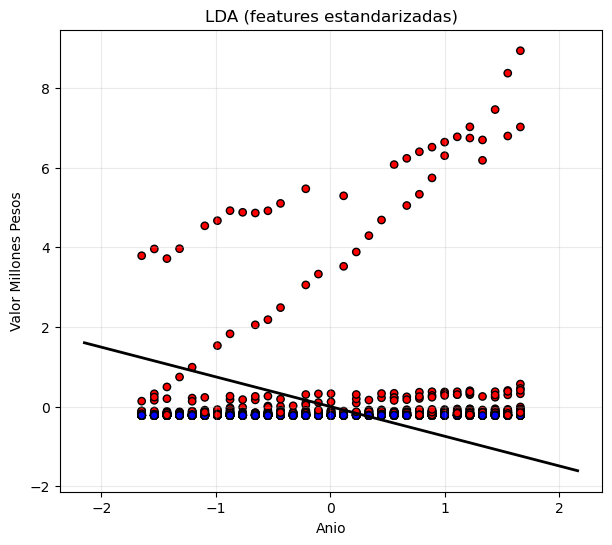

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

X2_tr = Xs_train[top2_vars].copy()
X2_te = Xs_test[top2_vars].copy()

lda = LinearDiscriminantAnalysis()
lda.fit(X2_tr, y_train)

w = lda.coef_.ravel()
b = lda.intercept_.ravel()[0]
x_line = np.linspace(X2_tr.iloc[:,0].min()-0.5, X2_tr.iloc[:,0].max()+0.5, 100)
y_line = (-(b + w[0]*x_line) / w[1])

plt.figure(figsize=(7,6))
plt.scatter(X2_tr.iloc[:,0], X2_tr.iloc[:,1],
            c=y_train, cmap="bwr", edgecolors="k", s=28)
plt.plot(x_line, y_line, color="black", linewidth=2)
plt.title("LDA (features estandarizadas)")
plt.xlabel(top2_vars[0].replace("_z","").replace("_"," ").title())
plt.ylabel(top2_vars[1].replace("_z","").replace("_"," ").title())
plt.grid(True, alpha=0.25)
plt.show()


Calculé el cost-complexity pruning path y evalué con KFold(4). En la tabla hay dos candidatos y sus acuracies promedio:
- α = 0.0 → 0.999231
- α = 0.5 → 0.486175
El mejor α es 0.0 (sin poda). La salida tambien lo reporta y la tabla con ambos valores

In [68]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, cross_val_score
import pandas as pd

base = DecisionTreeClassifier(random_state=55)
base.fit(X2_tr, y_train)
path = base.cost_complexity_pruning_path(X2_tr, y_train)
ccp_alphas = np.unique(path.ccp_alphas)

cv = KFold(n_splits=4, shuffle=True, random_state=55)
scores = []
for a in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=55, ccp_alpha=a)
    sc = cross_val_score(clf, X2_tr, y_train, cv=cv, scoring="accuracy").mean()
    scores.append((a, sc))
alpha_df = pd.DataFrame(scores, columns=["ccp_alpha","mean_acc"])\
            .sort_values(["mean_acc","ccp_alpha"], ascending=[False, True])\
            .reset_index(drop=True)
best_alpha = float(alpha_df.iloc[0]["ccp_alpha"])
print("Mejor α:", best_alpha)
alpha_df.head(10)



Mejor α: 0.0


,ccp_alpha,mean_acc
0,0.0,0.999231
1,0.5,0.486175


Con α = 0.0 entrené el árbol final. EL plot del árbol muestra un regla única en la raíz:
- valor_millones_pesos_z <= -0.215 - clase Bajo a la izquierda y Alto a la derecha
  El no raíz tiene samples = 1302 y value = (651, 651) el train esta balanceado. Ambos quedan con gini = 0.0 y 651 observaciones puras cada uno (todas Bajo a la izquierda, todas Alto a la derecha).
  En  la partición 2D, el fondo queda dividido por un umbral horizontal sobre valor_millones_pesos_z: la parte inferior (azul) es Bajo y el resto (rojo) es Alto. Esta imagen confrima que el árbol aprenció exactamente el umbral que define la clase

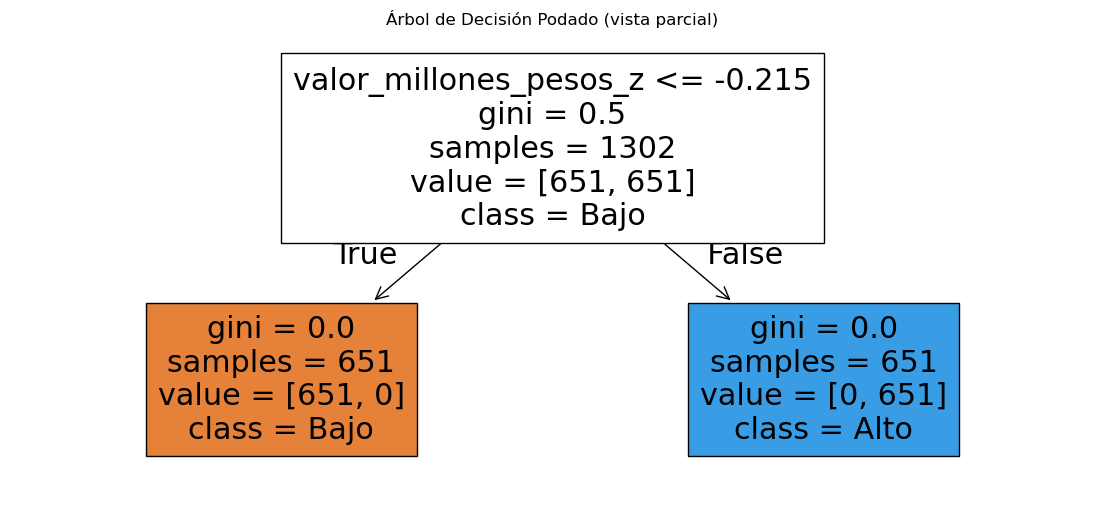

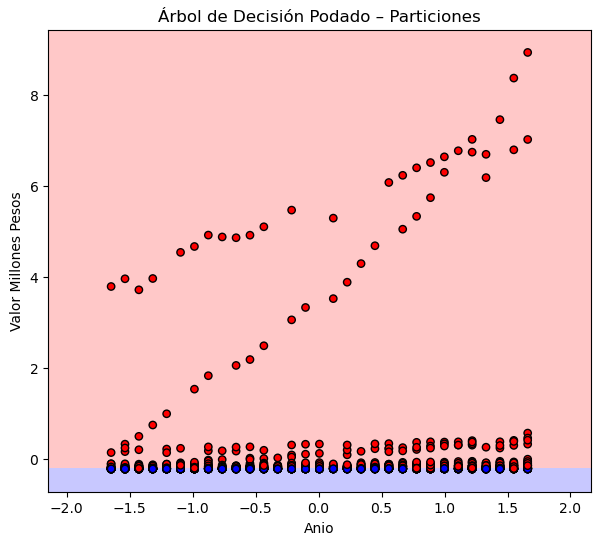

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tree = DecisionTreeClassifier(random_state=55, ccp_alpha=best_alpha)
tree.fit(X2_tr, y_train)

plt.figure(figsize=(14,6))
plot_tree(tree, filled=True, feature_names=list(X2_tr.columns),
          class_names=["Bajo","Alto"], max_depth=3)
plt.title("Árbol de Decisión Podado (vista parcial)")
plt.show()

x1_min, x1_max = X2_tr.iloc[:,0].min()-0.5, X2_tr.iloc[:,0].max()+0.5
x2_min, x2_max = X2_tr.iloc[:,1].min()-0.5, X2_tr.iloc[:,1].max()+0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 400),
                       np.linspace(x2_min, x2_max, 400))

grid_df = pd.DataFrame(
    np.c_[xx1.ravel(), xx2.ravel()],
    columns=X2_tr.columns
)
Zt = tree.predict(grid_df).reshape(xx1.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx1, xx2, Zt, alpha=0.25, cmap="bwr")
plt.scatter(X2_tr.iloc[:,0], X2_tr.iloc[:,1], c=y_train, cmap="bwr",
            edgecolors="k", s=28)
plt.title("Árbol de Decisión Podado – Particiones")
plt.xlabel(top2_vars[0].replace("_z","").replace("_"," ").title())
plt.ylabel(top2_vars[1].replace("_z","").replace("_"," ").title())
plt.show()


En esta celda evalúo los dos modelos en el conjunto de prueba usando las dos variables estandarizadas (anio_z, valor_millones_pesos_z). La salida imprime accuracy, precision, recall y F1 para cada modelo y dibuja dos matrices de confusión (LDA arriba, Árbol abajo). La codificación de clases es 0 = Bajo y 1 = Alto.

LDA (test).  
Los valores que obtuve son: Accuracy = 0.6147, Precision = 0.6923, Recall = 0.5516 y F1 = 0.6140.  
La matriz de confusión muestra: TN=172 (Bajo→Bajo), FP=76 (Bajo→Alto), FN=139 (Alto→Bajo) y TP=171 (Alto→Alto), con soportes de 248 para Bajo y 310 para Alto. Es decir, LDA acierta 172 bajos y 171 altos, pero pierde 139 altos (los predice como bajos), lo que explica el recall más bajo en la clase Alto. La frontera lineal separa parte del plano, pero hay mezcla relevante entre clases.

Árbol podado (test). 
Los valores son Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000 y F1 = 1.0000.  
La matriz de confusión es: TN=248, FP=0, FN=0, TP=310. Esto ocurre porque el árbol aprendido (con α = 0.0, seleccionado por CV 4-fold) divide por un umbral en valor_millones_pesos_z que coincide con cómo definí la etiqueta (Bajo/Alto respecto a la mediana del train). Por eso, la regla del árbol replica la definición de clase y generaliza sin errores en este test.



=== LDA ===
Accuracy: 0.6147 | Precision: 0.6923 | Recall: 0.5516 | F1: 0.6140

Reporte de clasificación:
               precision    recall  f1-score   support

        Bajo       0.55      0.69      0.62       248
        Alto       0.69      0.55      0.61       310

    accuracy                           0.61       558
   macro avg       0.62      0.62      0.61       558
weighted avg       0.63      0.61      0.61       558



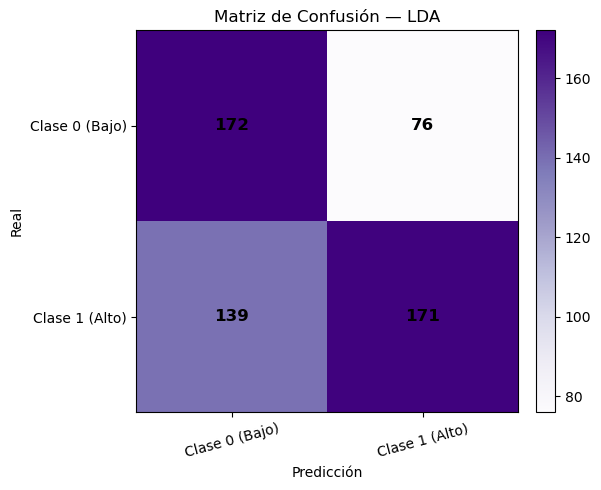


=== Árbol podado ===
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

Reporte de clasificación:
               precision    recall  f1-score   support

        Bajo       1.00      1.00      1.00       248
        Alto       1.00      1.00      1.00       310

    accuracy                           1.00       558
   macro avg       1.00      1.00      1.00       558
weighted avg       1.00      1.00      1.00       558



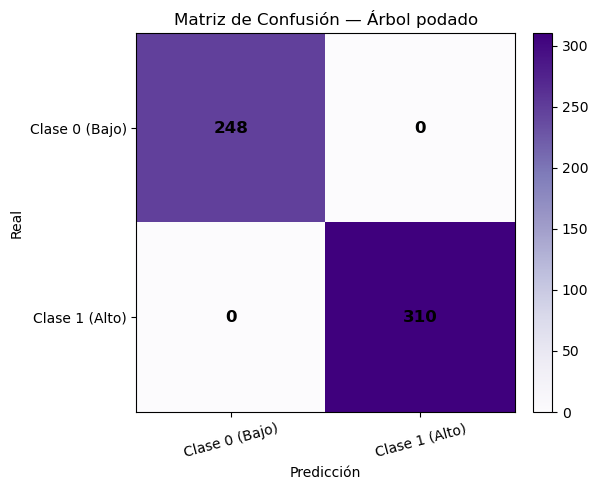

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def report_and_plot(model, X_te, y_te, titulo):
    yhat = model.predict(X_te)
    acc = accuracy_score(y_te, yhat)
    prec = precision_score(y_te, yhat)
    rec = recall_score(y_te, yhat)
    f1 = f1_score(y_te, yhat)
    print(f"\n=== {titulo} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("\nReporte de clasificación:\n", classification_report(y_te, yhat, target_names=["Bajo","Alto"], zero_division=0))

    cm = confusion_matrix(y_te, yhat)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="Purples")
    ax.set_title(f"Matriz de Confusión — {titulo}")
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    ax.set_xticks([0,1]); ax.set_xticklabels(["Clase 0 (Bajo)","Clase 1 (Alto)"], rotation=15)
    ax.set_yticks([0,1]); ax.set_yticklabels(["Clase 0 (Bajo)","Clase 1 (Alto)"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12, fontweight="bold")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

report_and_plot(lda, X2_te, y_test, "LDA")

report_and_plot(tree, X2_te, y_test, "Árbol podado")


Conclusión.  
Con estas dos variables y esta definición de clase, el árbol de decisión es claramente superior a LDA (0.6147 vs 1.0 de accuracy y F1). El resultado es coherente con la estructura del problema: la etiqueta se construye con un umbral y el árbol aprende precisamente esa regla de corte.